In [1]:
import math
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, uniform, chi2
import numpy as np
from scipy.stats.mstats import gmean
from numpy.testing import assert_allclose
from utils import sprt_mart, alpha_mart, shrink_trunc, stratum_selector, \
    multinomial_selector, get_global_pvalue, simulate_audits, round_robin
np.random.seed(123456789)

In [2]:
theta = 1/2 
hand_tally = np.concatenate((np.ones(50), np.zeros(30), np.ones(60), np.zeros(40)))
reported_tally = np.concatenate((np.ones(50), np.zeros(30), np.ones(70), np.zeros(30)))
omega = reported_tally - hand_tally
stratum_indicator = np.concatenate((np.ones(80), 2*np.ones(100)))


v = np.array([2 * np.mean(reported_tally[stratum_indicator == 1]) - 1, 
              2 * np.mean(reported_tally[stratum_indicator == 2]) - 1])
u = 2 / (2 - v)
stratum_1 = (1 - omega[stratum_indicator == 1]) / (2 - v[0])
stratum_2 = (1 - omega[stratum_indicator == 2]) / (2 - v[1])

In [3]:
p_value, stratum_selections, null_selections = get_global_pvalue(
    strata = [stratum_1, stratum_2], 
    u = u, 
    v = v, 
    rule = multinomial_selector)

In [5]:
#this is much slower than the R implementation in sweeter-than-sweet
stopping_times = simulate_audits(
    strata = [stratum_1, stratum_2], 
    u = u, 
    v = v, 
    rule = round_robin, 
    n_sims = 30, 
    alpha = .05)

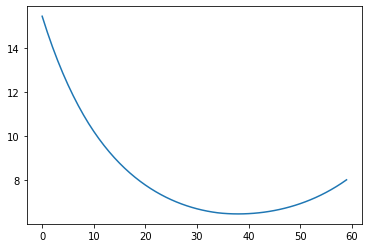

In [15]:
# topography of the P-value of the intersection null at a few sample sizes
strata = [stratum_1, stratum_2]
#rule = multinomial_selector
rule = round_robin

shuffled_1 = np.random.permutation(strata[0])
shuffled_2 = np.random.permutation(strata[1])
N = np.concatenate((np.array([len(shuffled_1)]), np.array([len(shuffled_2)])))
w = N/sum(N)
epsilon = 1 / (2*np.max(N))
theta_1_grid = np.arange(epsilon, u[0] - epsilon, epsilon) #sequence from epsilon to u[0] - epsilon
theta_2_grid = (1/2 - w[0] * theta_1_grid) / w[1]
strata_matrix = np.zeros((len(shuffled_1) + len(shuffled_2) - 1, len(theta_1_grid)))
intersection_marts = np.zeros((len(shuffled_1) + len(shuffled_2), len(theta_1_grid)))
mart_1 = np.zeros((len(shuffled_1), len(theta_1_grid)))
mart_2 = np.zeros((len(shuffled_2), len(theta_1_grid)))
for i in range(len(theta_1_grid)):
    mart_1[:,i], mu_1 = alpha_mart(x = shuffled_1, N = N[0], mu = theta_1_grid[i], eta = 1/(2-v[0]), f = .01, u = u[0])
    mart_2[:,i], mu_2 = alpha_mart(x = shuffled_2, N = N[1], mu = theta_2_grid[i], eta = 1/(2-v[1]), f = .01, u = u[1])
    strata_matrix[:,i], intersection_marts[:,i] = stratum_selector(
        marts = [mart_1[:,i], mart_2[:,i]],
        mu = [mu_1, mu_2],
        u = u,
        rule = rule)
null_index = np.argmin(intersection_marts, axis = 1)
#stratum_selections = strata_matrix[1:sum(N), null_index]
#minimized_martingale = intersection_marts[1:sum(N), null_index]
minimized_martingale = np.ones(sum(N))
stratum_selections = np.ones(sum(N) - 1) * np.inf
for i in np.arange(sum(N) - 1):
    minimized_martingale[i] = intersection_marts[i,null_index[i]]
    stratum_selections[i] = strata_matrix[i,null_index[i]]
maximized_p_values = 1 / np.maximum(1, minimized_martingale)
plt.plot(intersection_marts[10,70:130])

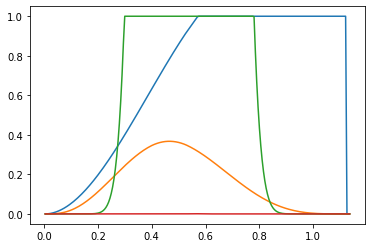

In [16]:
#the below plots are smooth if the rule is round robin, and not at all smooth if it is the intersection martingale
#it might have to do with the fact that different samples are used for every value of theta_1_grid...
#this doesn't happen in the R code: the contours of the intersection martingale are smooth,
#but in that implementation there is no auxiliary randomness
thresholded_marts = intersection_marts
thresholded_marts[intersection_marts < 1] = 1
all_p_values = 1/thresholded_marts
plt.plot(theta_1_grid, all_p_values[1,:])
plt.plot(theta_1_grid, all_p_values[5,:])
plt.plot(theta_1_grid, all_p_values[30,:])
plt.plot(theta_1_grid, all_p_values[100,:])